# Set up

## Package Loading

In [1]:
import pandas as pd
import numpy as np
import itertools
#!pip install emoji
#!pip install imblearn
import emoji
import re
#!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib

#from google.colab import drive
#drive.mount('/content/drive')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\timja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\timja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Set Up paths

In [7]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = 'C:/Users/timja/OneDrive/Dokumente/TeamProject/detecting_harmful_content-main/'
parent_path = local_path

#Specific paths
path_train = parent_path+"data/external/Harmful_and_Cyberbullying/data.csv" 
#path_test = parent_path+"data/external/Harmful/test_tweet.csv" 
path_preprocessed = parent_path+"data/processed/Harmful_and_Cyberbullying/preprocessed_data_final.csv" 

path_hyperparameters_sgd = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/sgd.csv"
path_hyperparameters_svm = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/svm.csv"
path_hyperparameters_et = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/et.csv"
path_hyperparameters_rf = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/rf.csv"
path_hyperparameters_nb = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/nb.csv"
path_hyperparameters_knn = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/knn.csv"
path_hyperparameters_lr = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/lr.csv"
path_hyperparameters_dt = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/dt.csv"

path_best_parameters_sgd = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/sgd.pkl"
path_best_parameters_svm = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/svm.pkl"
path_best_parameters_et = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/et.pkl"
path_best_parameters_rf = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/rf.pkl"
path_best_parameters_nb = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/nb.pkl"
path_best_parameters_knn = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/knn.pkl"
path_best_parameters_lr = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/lr.pkl"
path_best_parameters_dt = parent_path+"models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/dt.pkl"

# Balance Dataset

In [8]:
# loading preprocessd data
df = pd.read_csv(path_preprocessed)
df = df[df['text'].apply(lambda x: isinstance(x, str))] # Temporal solution

<AxesSubplot:>

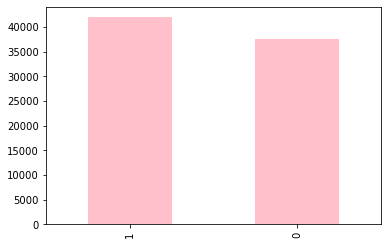

In [9]:
df['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

## Train, Validation, Test Split

In [11]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
x_train = x_train['text']
#del x_train['label']

y_test = x_test['label']
x_test = x_test['text']
#del x_test['label']

y_valid = x_valid['label']
x_valid = x_valid['text']
#del x_valid['label']

x_train= x_train.append(x_valid, ignore_index=True)
y_train= y_train.append(y_valid, ignore_index=True)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)
display(x_train)

(71686,)
(7966,)
(7965,)


0        Wow typical . “ Colored people ” ? ? Wow ... d...
1                I class cause foggy outside . # dangerous
2        # angel # archangel high help live # spiritual...
3                      @ aayyyBAYBAY grabbed cheek . # WTF
4        happy year ! # lovinglife # bestdecisionever #...
                               ...                        
71681               @ LizQuilty I heard . But I eye open .
71682                      friend playing work ð # rhcp
71683     # friday ! # eso later evening ! # fridayfeeling
71684    I anti-Semitic Breaking Bad & gt ; & gt ; Bett...
71685    father ! # smile # lifeisgood # live # life # ...
Name: text, Length: 71686, dtype: object

# Training Models in a Pipeline

## Pipeline Set Up

In [12]:
# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
f1 = make_scorer(f1_score)

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


## Naïve Bayes

In [14]:
# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 479.05526208877563 seconds ---
Multinomial NBClassifier: 88.45278463576508% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 1, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l1', 'vectorizer__smooth_idf': True}


['C:/Users/timja/OneDrive/Dokumente/TeamProject/detecting_harmful_content-main/models/English/Classical_approach/Harmful_and_Cyberbullying/Hyperparameters/best_parameters/nb.pkl']